In [105]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [106]:
cd ~/workspace/theislab/mubind/notebooks/scatac

/mnt/c/Users/ignacio.ibarra/Dropbox/workspace/theislab/mubind/notebooks/scatac


In [107]:
import mubind as mb
import numpy as np
import pandas as pd
import torch
import bindome as bd
bd.constants.ANNOTATIONS_DIRECTORY = 'annotations'
# mb.models.MultiBind
import torch.optim as topti
import torch.utils.data as tdata
import matplotlib.pyplot as plt
import logomaker
import os
import scipy
import pickle

# Use a GPU if available, as it should be faster.
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Using device: " + str(device))

Using device: cuda:0


In [108]:
atac_path = '../../annotations/scatac/pancreas_multiome_2022_processed_sample_10000.h5ad'
os.path.exists(atac_path)

True

In [109]:
import scanpy as sc
adata = sc.read_h5ad(atac_path)

In [110]:
adata.shape

(10000, 10000)

In [111]:
adata.shape

(10000, 10000)

In [112]:
adata = adata[:,adata.var.modality == 'ATAC'].copy()

n_sample_cells = 100
n_sample_peaks = 100
obs_sample = pd.Series(adata.obs_names).sample(n_sample_cells)
var_sample = pd.Series(adata.var_names).sample(n_sample_peaks)

adata = adata[adata.obs_names.isin(obs_sample),adata.var_names.isin(var_sample)]

In [113]:
adata.shape

(100, 100)

In [114]:
adata.shape

(100, 100)

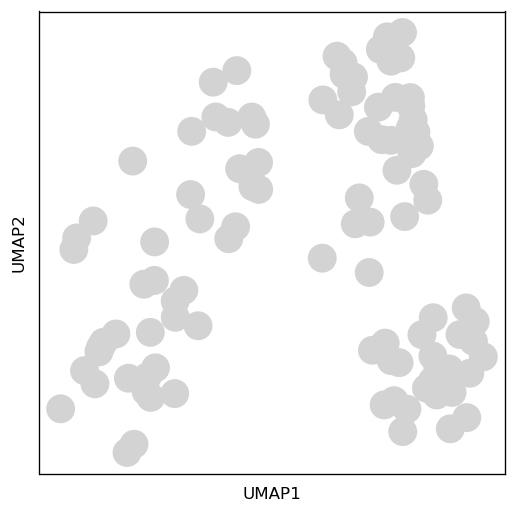

In [115]:
sc.pl.umap(adata)

In [116]:
adata.var

,modality
1-96883502-96884426,ATAC
1-121709111-121710069,ATAC
1-125496731-125497628,ATAC
1-131708079-131708972,ATAC
1-133492663-133493605,ATAC
...,...
19-21805127-21805964,ATAC
19-27447216-27448115,ATAC
19-47711209-47712126,ATAC
19-55267931-55268843,ATAC


In [117]:
adata.var['chr'] = 'chr' + adata.var_names.str.split('-').str[0]
adata.var['start'] = adata.var_names.str.split('-').str[1].astype(int)
adata.var['end'] = adata.var_names.str.split('-').str[2].astype(int)

In [118]:
extend = 50

adata.var['chr'].value_counts()

chr4     9
chr7     9
chr9     8
chr5     8
chr1     7
chr3     7
chr10    6
chr11    6
chr6     5
chr2     5
chr15    5
chr17    5
chr19    5
chr12    3
chr13    3
chr18    3
chr8     2
chr16    2
chr14    1
chrX     1
Name: chr, dtype: int64

In [119]:
adata.var['summit'] = ((adata.var['end'] + adata.var['start']) / 2).astype(int)
adata.var['summit.start'] = adata.var['summit'] - extend
adata.var['summit.end'] = adata.var['summit'] + extend

In [120]:
adata.var['k.summit'] = adata.var['chr'] + ':' + adata.var['summit.start'].astype(str) + '-' + adata.var['summit.end'].astype(str)

In [121]:
adata.shape

(100, 100)

In [122]:
n_seqs = 10000 # adata.shape[1] # None # 1000
seqs = mb.bindome.tl.get_sequences_from_bed(adata.var[['chr', 'summit.start', 'summit.end']].head(n_seqs), genome='mm10', uppercase=True,
                                            gen_path='../../annotations/mm10/genome/mm10.fa')
keys = set([s[0] for s in seqs])
adata = adata[:,adata.var['k.summit'].isin(keys)]
# seqs = [[s[0], s[1].upper()] for s in seqs[0]]

/tmp/tmplh1emeqq
genome mm10 True
../../annotations/mm10/genome/mm10.fa
True ../../annotations/mm10/genome/mm10.fa
running bedtools...
bedtools getfasta -fi ../../annotations/mm10/genome/mm10.fa -bed /tmp/tmplh1emeqq -fo /tmp/tmpf939oqu6


In [123]:
len(seqs)

100

In [124]:
# remove Ns
for s in seqs:
    if 'N' in s:
        assert False
    # seqs = [[s[0], s[1].replace('N', '')] for s in seqs]
counts = adata.X.T

In [125]:
next_data = pd.DataFrame(counts.A) # sparse.from_spmatrix(counts.A)
# next_data = pd.DataFrame.sparse.from_spmatrix(counts)# var = []
# for ri, r in next_data.iterrows():
#     if ri % 1000 == 0:
#         print(ri, next_data.shape)
#     # print(ri, r.values[:-1], r.values[:-1].var())
#     var.append(r.values[:-1].var())
#     # break



In [126]:
next_data['var'] = next_data.var(axis=1)
# next_data = next_data[range(100)].copy()

In [127]:
next_data.index = [s[1] for s in seqs]
next_data.index.name = 'seq'
next_data.shape

(100, 101)

In [128]:
# sum_index = next_data[next_data.columns[:-1]].var(axis=1).sort_values(ascending=False).index

In [129]:
n_cells = 10000
top_var = next_data[['var']].sort_values('var', ascending=False).index[:n_cells]

In [130]:
# next_data = next_data.head(10000)
next_data_sel = next_data.reindex(top_var) # .reset_index(drop=True)

In [131]:
next_data_sel

,0,1,2,3,4,5,6,7,8,9,...,91,92,93,94,95,96,97,98,99,var
seq,,,,,,,,,,,,,,,,,,,,,
TGACGCAAACATAAGTGCGACGCACGCCGCTCGGGGAGGGGTCTTGAGGAGGGGGCTGCGGCCTGCTGGGCTGGATGAATGAGGGCTGGCGCCCTGCGGC,0.0,3.0,0.0,0.0,0.0,0.0,2.0,2.0,0.0,2.0,...,2.0,0.0,1.0,0.0,1.0,2.0,0.0,1.0,0.0,0.951111
CGGGAACGCTGAGGCTAATTGCGGCCGCTGCTCTCCATCCCGACAGTACAACCGCCGCCGCGCCCTCAGAGGAGGCGCTTCCCGAAAGCCCGTCTGTTCC,0.0,0.0,2.0,4.0,0.0,1.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.841515
CAGCCCACTCCCGCCCGCCCAGCCCGACTGAGGGGGCCTGGAGCCCATCTCGGAGCGCACTCATAACGGAAGCCCGCGCAGATGGGAGCAAGAGGTCTTT,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.452020
GCGGCGGGGCTGGTGGGCCCCATGTCCGGGCCTCGGGCCCTCACGTCCCCTGCGCTCCCGCCCGGCCCTACCCGGCCCCAGCGGTGACAGGAGCTCCCAG,0.0,1.0,0.0,1.0,0.0,1.0,2.0,0.0,0.0,3.0,...,0.0,0.0,0.0,1.0,2.0,0.0,0.0,0.0,0.0,0.448081
CGCGGCGAGGCGCTGGCCGCCTACCTGGATGGCCGCGAGCCGGTGCTGCGGTTCAGACCACGAGAGGAAGAGGCGCTGTTGGGCGAGATCGTGCGAGCTG,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.355152
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ATGTTTCAGCTTTTAACTATGCTCCATATAGAAAGGGGGGCGGGGAGGTGAGCAGGAGGTGCCGGGCTGCCAGATGGTCAATGAGTCAGCCAAGATAGTC,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
CCCCCCACAGACAAAGGCCAGAACCTCTCAGGGTAAAGAGCCTGGTACAGGGGCGGGGCTGGGATCCACACAGACTTACCTAACTCAGGGCCCCATACGC,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
TAACAGCTATCCAGATAAGTGCTACCTAGGCCTTAACATTTTTCTAGGCCTTAATATTCCATCTAGGCCTTAATATTTTACCTACATCTTAACAGGAAGC,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000


In [132]:
del next_data_sel['var']
# next_data_sel.index = next_data_sel['seq']
# del next_data_sel['seq']

In [133]:
df = next_data_sel.copy() # sample
# df = df[df.columns[:5000]] # .head(100) # sample

# shorten sequences/remove duplicates
# df.index = df.index.astype(str).str[35:-35]
# df = df[~df.index.duplicated(keep='first')]

zero_counts = df.sum(axis=1) == 0
df = df[~zero_counts] # remove zeroes

df.shape

(89, 100)

In [134]:
df2 = df.reset_index().melt('seq').set_index('seq')
# add a baseline count
df2[0] = 1.0
cols = ['batch', 1, 0]
df2.columns = cols
df2 = df2[[0, 1, 'batch']] # cols[::-1]]
df2['batch'] = df2['batch'].astype(int)
print(df2.shape)
print(len(set(df2['batch'])))
n_cells = 200
df2 = df2[df2['batch'].isin(range(0, n_cells))]
print(df2['batch'].value_counts())
df2.head()

(8900, 3)
100
0     89
63    89
73    89
72    89
71    89
      ..
30    89
29    89
28    89
27    89
99    89
Name: batch, Length: 100, dtype: int64


,0,1,batch
seq,,,
TGACGCAAACATAAGTGCGACGCACGCCGCTCGGGGAGGGGTCTTGAGGAGGGGGCTGCGGCCTGCTGGGCTGGATGAATGAGGGCTGGCGCCCTGCGGC,1.0,0.0,0
CGGGAACGCTGAGGCTAATTGCGGCCGCTGCTCTCCATCCCGACAGTACAACCGCCGCCGCGCCCTCAGAGGAGGCGCTTCCCGAAAGCCCGTCTGTTCC,1.0,0.0,0
CAGCCCACTCCCGCCCGCCCAGCCCGACTGAGGGGGCCTGGAGCCCATCTCGGAGCGCACTCATAACGGAAGCCCGCGCAGATGGGAGCAAGAGGTCTTT,1.0,0.0,0
GCGGCGGGGCTGGTGGGCCCCATGTCCGGGCCTCGGGCCCTCACGTCCCCTGCGCTCCCGCCCGGCCCTACCCGGCCCCAGCGGTGACAGGAGCTCCCAG,1.0,0.0,0
CGCGGCGAGGCGCTGGCCGCCTACCTGGATGGCCGCGAGCCGGTGCTGCGGTTCAGACCACGAGAGGAAGAGGCGCTGTTGGGCGAGATCGTGCGAGCTG,1.0,0.0,0


### This is the relatedness graph and used for dynamics filters learning

In [135]:
# sum(adata.obs_names.isin(df.index)

In [136]:
len(seqs)

100

In [137]:
rel = adata[:,~zero_counts].uns['neighbors']['connectivities'].A
# rel[:n_cells,:n_cells].sum()
rel.shape

(100, 100)

In [138]:
rel.shape

(100, 100)

In [139]:
# df2 = []
# for i in df.columns:
#     df3 = df[[i]].copy()
#     df3 = df3.head(100)
#     df3.columns = [0]
#     df3[1] = 1 # need a minimal non-zero count
#     df3['batch'] = i
#     df2.append(df3)
# df2 = pd.concat(df2)
# # df2['is_count_data'] = True
# dataset = mb.datasets.SelexDataset(df2, n_rounds=2, labels=[0, 1], enr_series=False)
dataset = mb.datasets.SelexDataset(df, n_rounds=df.shape[1], enr_series=False)
len(set(dataset.batch))

1

In [140]:
n_batch = len(set(dataset.batch))
n_batch

1

In [141]:
# df = next_data_sel.copy()
# dataset = mb.datasets.GenomicsDataset(df)
# train = tdata.DataLoader(dataset=dataset, batch_size=1000, shuffle=True)

train = tdata.DataLoader(dataset=dataset, batch_size=1024, shuffle=True)


In [142]:
# log_etas = torch.tensor(np.log(df.sum(axis=0) / df.sum().sum())).reshape(1, n_batch).to(device)
# log_etas

In [143]:
b = np.random.randint(0, 2, (3, 4))
conn = np.random.randint(0, 2, (4, 4))

In [144]:
import torch.optim as topti
import warnings
warnings.filterwarnings("ignore")

criterion = mb.tl.PoissonLoss()

n_kernels = 4
model = mb.models.Multibind.make_model(train, n_kernels, criterion, kernels=[0, 2] + [20] * (n_kernels - 2),
                                       # use_dinuc=True, dinuc_mode='full',
                                       optimize_sym_weight=False,
                                       optimize_exp_barrier=True,
                                       optimize_log_dynamic=False,
                                       use_dinuc=False,
                                       device=device,
                                       dinuc_mode=None).cuda()

# Init
def triu_init(m):
    with torch.no_grad():
        m.weight.copy_(torch.triu(m.weight))

# Zero out gradients
def get_zero_grad_hook(mask):
    def hook(grad):
        return grad * mask

    return hook

mask = torch.tril(torch.ones_like(model.selex_module.log_dynamic), -1)
print(mask.device)
print(model.selex_module.log_dynamic)

model.selex_module.log_dynamic.register_hook(get_zero_grad_hook(mask))


# here we set up the relationships between cells using the knn graph, for graph-based learning of activities
model.selex_module.connectivities = torch.tensor(rel).cuda()

cuda:0
Parameter containing:
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]], device='cuda:0', requires_grad=True)


In [145]:
%load_ext line_profiler

The line_profiler extension is already loaded. To reload it, use:
  %reload_ext line_profiler


In [146]:
# %lprun -f model.selex_module.forward model.optimize_iterative(train, n_epochs=[500] + [200] * (n_kernels - 1), show_logo=False, use_mono=True, use_dinuc=False)

In [147]:
model, best_loss = model.optimize_iterative(train, n_epochs=[500] + [200] * (n_kernels - 1), show_logo=False, use_mono=True, use_dinuc=False, dinuc_mode='local',
                                            opt_kernel_shift=[0, 0] + [1] * (n_kernels - 2),
                                            opt_kernel_length=[0, 0] + [1] * (n_kernels - 2),
                                            shift_max=1, shift_step=1, optimiser=topti.Adam,
                                            n_batches=1, n_rounds=2, num_epochs_shift_factor=1, # log_etas=log_etas, # log_etas=log_etas,
                                            kernels = [0] + [2] + [20] * (n_kernels - 2), r2_per_epoch=True,
                                            exp_max=8,
                                            early_stopping=50, log_each=10, w=20, max_w=20) #  target_dim=train.dataset.signal.shape[1])

current kernels

Kernel to optimize 0

FREEZING KERNELS
optimizing feature type mono
setting grad status of kernel (mono, dinuc) at 0 to (1, 0)
setting grad status of kernel (mono, dinuc) at 1 to (0, 0)
setting grad status of kernel (mono, dinuc) at 2 to (0, 0)
setting grad status of kernel (mono, dinuc) at 3 to (0, 0)
kernels mask None
optimizer:  Adam 
criterion: PoissonLoss 
# epochs: 500 
early_stopping: 50
lr= 0.01, weight_decay= 0, dir weight= 0
Epoch: 11, Loss: 0.216615, R2: 0.17,  best epoch: 9,  secs per epoch: 0.015 s,  secs epoch*1k trials: 0.165s
Epoch: 21, Loss: 0.213568, R2: 0.18,  best epoch: 19,  secs per epoch: 0.016 s,  secs epoch*1k trials: 0.180s
Epoch: 31, Loss: 0.211676, R2: 0.19,  best epoch: 29,  secs per epoch: 0.015 s,  secs epoch*1k trials: 0.170s
Epoch: 41, Loss: 0.210534, R2: 0.19,  best epoch: 39,  secs per epoch: 0.017 s,  secs epoch*1k trials: 0.195s
Epoch: 51, Loss: 0.209839, R2: 0.20,  best epoch: 49,  secs per epoch: 0.016 s,  secs epoch*1k trials: 0.

True
4


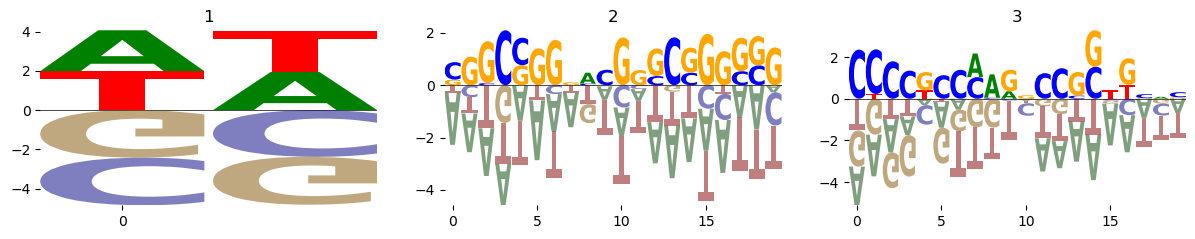

In [148]:
from matplotlib import rcParams
rcParams['figure.figsize'] = 20, 5
rcParams['figure.dpi'] = 100
mb.pl.conv(model, n_cols=2, show=True)
plt.show()


In [149]:
log_dynamic = model.selex_module.log_dynamic
log_dynamic = log_dynamic + -torch.transpose(log_dynamic, 0, 1)
# triu_indices = torch.triu_indices(row=n_rounds, col=n_rounds, offset=1)
log_dynamic

tensor([[ 0.00, -1.20,  1.48,  ...,  1.17,  3.51, -0.54],
        [ 1.20,  0.00,  2.15,  ...,  1.33,  1.05,  3.31],
        [-1.48, -2.15,  0.00,  ...,  0.09, -0.75, -1.20],
        ...,
        [-1.17, -1.33, -0.09,  ...,  0.00, -0.26,  1.60],
        [-3.51, -1.05,  0.75,  ...,  0.26,  0.00,  1.76],
        [ 0.54, -3.31,  1.20,  ..., -1.60, -1.76,  0.00]], device='cuda:0',
       grad_fn=<AddBackward0>)

<AxesSubplot: >

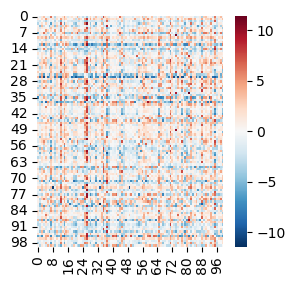

In [150]:
import seaborn as sns
mb.pl.set_rcParams({'figure.figsize': [3, 3]})
sns.heatmap(log_dynamic.detach().cpu(), cmap='RdBu_r')

<AxesSubplot: xlabel='index', ylabel='r2'>

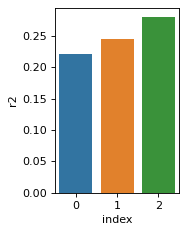

In [151]:
# contributions per newly added kernel
rcParams['figure.figsize'] = 2, 3
rcParams['figure.dpi'] = 80
import seaborn as sns
r2 = pd.DataFrame(model.best_r2_by_new_filter, columns=['r2']).reset_index()
sns.barplot(data=r2, x='index', y='r2')

In [152]:
log_dynamic = model.selex_module.log_dynamic
log_dynamic

Parameter containing:
tensor([[ 0.00, -0.41,  0.88,  ...,  0.32,  1.55, -0.00],
        [ 0.79,  0.00,  0.83,  ...,  0.40,  0.33,  1.46],
        [-0.60, -1.32,  0.00,  ..., -0.18, -0.52, -0.68],
        ...,
        [-0.85, -0.93, -0.28,  ...,  0.00,  0.12,  1.06],
        [-1.96, -0.72,  0.23,  ...,  0.38,  0.00,  1.13],
        [ 0.54, -1.85,  0.51,  ..., -0.54, -0.63,  0.00]], device='cuda:0',
       requires_grad=True)

In [153]:
torch.set_printoptions(precision=2)
log_dynamic = log_dynamic.detach().cpu().numpy()

n_rounds = model.selex_module.n_rounds
triu_indices = torch.triu_indices(row=n_rounds, col=n_rounds, offset=1)
log_dynamic[triu_indices[0], triu_indices[1]] = 0
dynamic_score = log_dynamic.sum(axis=0)


In [154]:

# dyn_score
dynamic_score = dynamic_score
dynamic_score = (dynamic_score - dynamic_score.min()) / (dynamic_score.max() - dynamic_score.min())
adata.obs['dynamic_score'] = dynamic_score

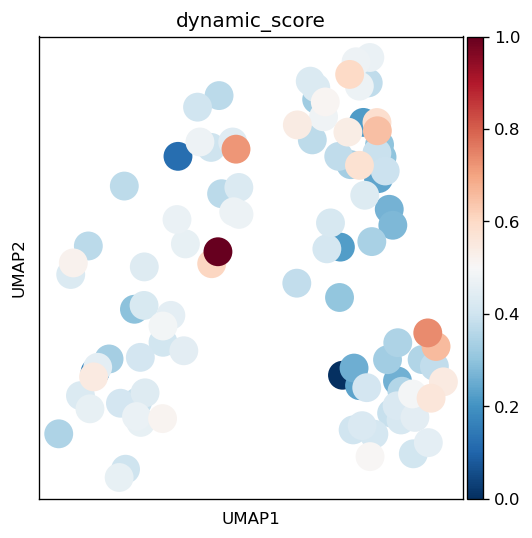

In [155]:
# contributions per newly added kernel
rcParams['figure.figsize'] = 5, 5
rcParams['figure.dpi'] = 120
sc.pl.umap(adata, color='dynamic_score', cmap='RdBu_r', sort_order=True)


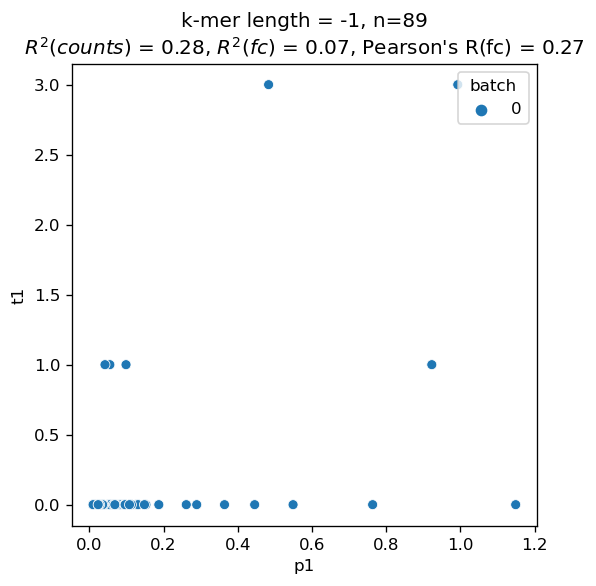

{'r2_counts': 0.28092087768641794,
 'r2_foldchange': 0.05858787935111831,
 'r2_enr': 0.03689123130911365,
 'r2_fc': 0.07473083783648715,
 'pearson_foldchange': 0.2733694164248941}

In [156]:
mb.pl.kmer_enrichment(model, train, log_scale=False, style='scatter', ylab='t1', xlab='p1')

In [157]:
import resource
print('total GB used:', resource.getrusage(resource.RUSAGE_SELF).ru_maxrss / 1e6)


total GB used: 4.490944
